In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

Read built-in FMNIST dataset in the torchvision.
And transforms the image intensity from -1 to 1.

In [16]:
data_dir = os.path.join('..', 'data', 'FMNIST')

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])
trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=1)

Show some data

Label: 7          3          7          3


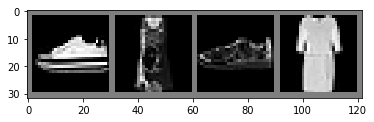

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Label:', '          '.join('{}'.format(labels[j].item()) for j in range(4)))

Define our neural network

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 36)
        self.fc3 = nn.Linear(36, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Model architecgture

In [23]:
net

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=36, bias=True)
  (fc3): Linear(in_features=36, out_features=10, bias=True)
)

Number of model parameters in each layer (includes weight & bias)

In [24]:
params = list(net.parameters())
print([x.size() for x in params])

[torch.Size([8, 1, 5, 5]), torch.Size([8]), torch.Size([16, 8, 5, 5]), torch.Size([16]), torch.Size([120, 256]), torch.Size([120]), torch.Size([36, 120]), torch.Size([36]), torch.Size([10, 36]), torch.Size([10])]


Define loss function & optimizer

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training

In [29]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[{}, {}] loss: {:.3f}'.format(
                    epoch + 1,
                    i + 1,
                    running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1, 2000] loss: 1.315
[1, 4000] loss: 0.672
[1, 6000] loss: 0.576
[1, 8000] loss: 0.518
[1, 10000] loss: 0.479
[1, 12000] loss: 0.459
[1, 14000] loss: 0.444
[2, 2000] loss: 0.407
[2, 4000] loss: 0.380
[2, 6000] loss: 0.368
[2, 8000] loss: 0.372
[2, 10000] loss: 0.361
[2, 12000] loss: 0.367
[2, 14000] loss: 0.341
Finished Training


Example test images

GroundTruth:      9     2     1     1


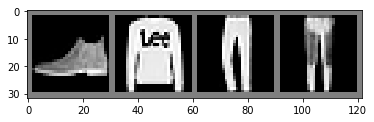

In [43]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{:5}'.format(labels[j]) for j in range(4)))

Prediction of these examples

In [44]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('{:5}'.format(predicted[j]) for j in range(4)))

Predicted:      9     2     1     1


Calculate accuracy

In [41]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {:.2%}'.format(correct / total))

Accuracy of the network on the 10000 test images: 87.29%


Accuracy of each class

In [45]:
classes = ['0 T-shirt/top','1 Trouser','2 Pullover','3 Dress','4 Coat',
           '5 Sandal','6 Shirt','7 Sneaker','8 Bag','9 Ankle boot']

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of {:5} : {:.2%}'.format(
        classes[i], class_correct[i] / class_total[i]))

Accuracy of 0 T-shirt/top : 78.90%
Accuracy of 1 Trouser : 97.20%
Accuracy of 2 Pullover : 78.50%
Accuracy of 3 Dress : 91.40%
Accuracy of 4 Coat : 79.40%
Accuracy of 5 Sandal : 96.20%
Accuracy of 6 Shirt : 64.80%
Accuracy of 7 Sneaker : 95.50%
Accuracy of 8 Bag : 96.80%
Accuracy of 9 Ankle boot : 94.20%
